In [3]:
import pandas as pd;
import numpy as np;
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import shap 

fraud_data = pd.read_csv('../data/raw/Fraud_Data.csv')
ip_data = pd.read_csv('../data/raw/IpAddress_to_Country.csv')
credit_card_data = pd.read_csv('../data/raw/creditcard.csv')

# Drop irrelevant columns of fraud data and avoid high-cardinality columns
fraud_features = fraud_data.drop(['class', 'ip_address', 'signup_time', 'purchase_time', 'device_id'], axis=1)
fraud_features = pd.get_dummies(fraud_features)
fraud_target = fraud_data['class']


# Train-test split
Xf_train, Xf_test, yf_train, yf_test = train_test_split(fraud_features, fraud_target, test_size=0.3, stratify=fraud_target, random_state=42)

# Drop irrelevant columns of credit card data
credit_card_features = credit_card_data.drop('Class', axis=1)
credit_card_target = credit_card_data['Class']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(credit_card_features, credit_card_target, test_size=0.3, stratify=credit_card_target, random_state=42)

d:\Projects\kifiyaAIMastery\improved-fraud-detection\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Model Training and Evaluation

# Define a helper function for evaluation:
def evaluate_model(model, X_test, y_test, dataset_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"--- Evaluation Report: {dataset_name} ---")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = average_precision_score(y_test, y_proba)
    
    plt.plot(recall, precision, marker='.', label=f"{dataset_name} (AUC-PR = {auc_pr:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return f1_score(y_test, y_pred), auc_pr


--- Evaluation Report: Fraud_Data - Logistic ---
[[41089     0]
 [ 4245     0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     41089
           1       0.00      0.00      0.00      4245

    accuracy                           0.91     45334
   macro avg       0.45      0.50      0.48     45334
weighted avg       0.82      0.91      0.86     45334



d:\Projects\kifiyaAIMastery\improved-fraud-detection\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\kifiyaAIMastery\improved-fraud-detection\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\kifiyaAIMastery\improved-fraud-detection\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

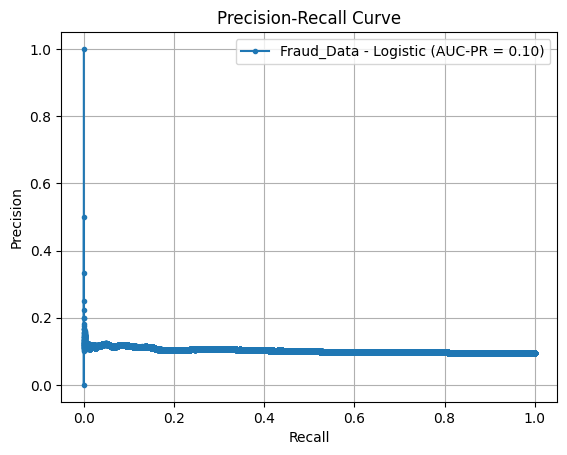

d:\Projects\kifiyaAIMastery\improved-fraud-detection\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:53:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Evaluation Report: Fraud_Data - XGBoost ---
[[41050    39]
 [ 4128   117]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     41089
           1       0.75      0.03      0.05      4245

    accuracy                           0.91     45334
   macro avg       0.83      0.51      0.50     45334
weighted avg       0.89      0.91      0.87     45334



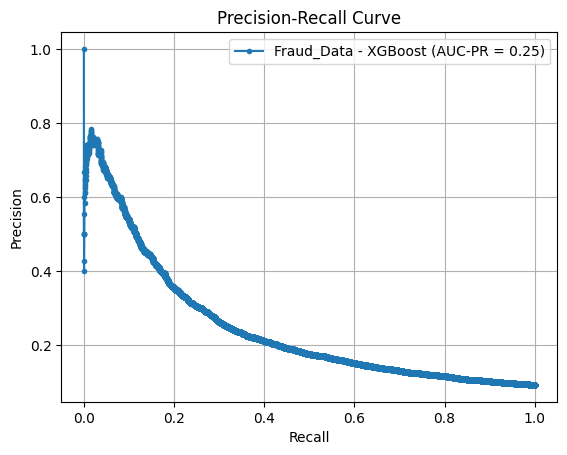

In [5]:
# Train on Fraud Data File
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(Xf_train, yf_train)
f1_log_fraud, aucpr_log_fraud = evaluate_model(logreg, Xf_test, yf_test, "Fraud_Data - Logistic")

# XGBoost Classifier
xgb_fraud = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_fraud.fit(Xf_train, yf_train)
f1_xgb_fraud, aucpr_xgb_fraud = evaluate_model(xgb_fraud, Xf_test, yf_test, "Fraud_Data - XGBoost")

d:\Projects\kifiyaAIMastery\improved-fraud-detection\venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Evaluation Report: CreditCard - Logistic ---
[[85276    19]
 [   52    96]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.83      0.65      0.73       148

    accuracy                           1.00     85443
   macro avg       0.92      0.82      0.86     85443
weighted avg       1.00      1.00      1.00     85443



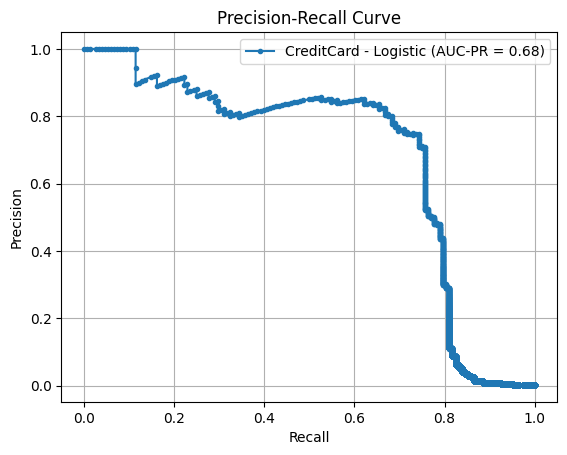

d:\Projects\kifiyaAIMastery\improved-fraud-detection\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:53:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Evaluation Report: CreditCard - XGBoost ---
[[85288     7]
 [   36   112]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.76      0.84       148

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



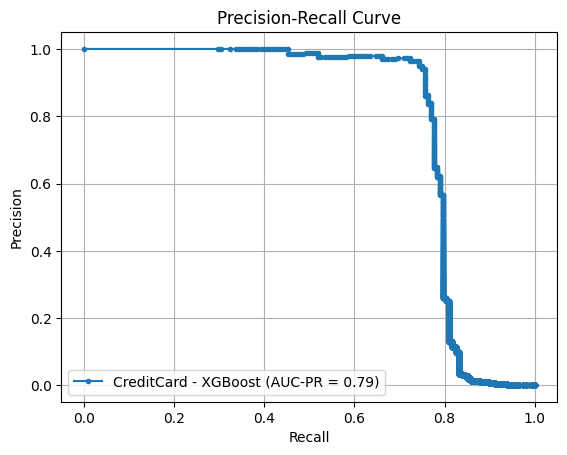

In [6]:
# Train on Credit Card Data File
# Logistic Regression
logreg_cc = LogisticRegression(max_iter=1000)
logreg_cc.fit(Xc_train, yc_train)
f1_log_cc, aucpr_log_cc = evaluate_model(logreg_cc, Xc_test, yc_test, "CreditCard - Logistic")

# XGBoost Classifier
xgb_cc = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_cc.fit(Xc_train, yc_train)
f1_xgb_cc, aucpr_xgb_cc = evaluate_model(xgb_cc, Xc_test, yc_test, "CreditCard - XGBoost")

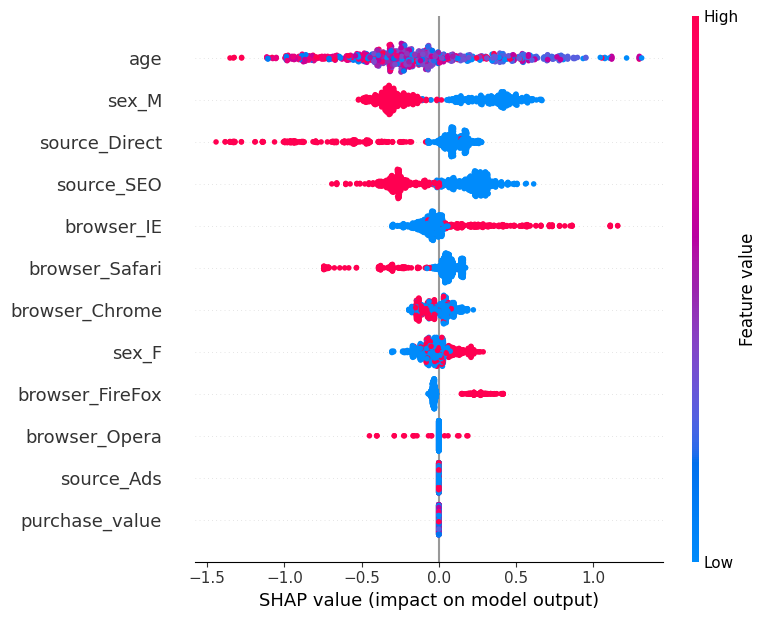

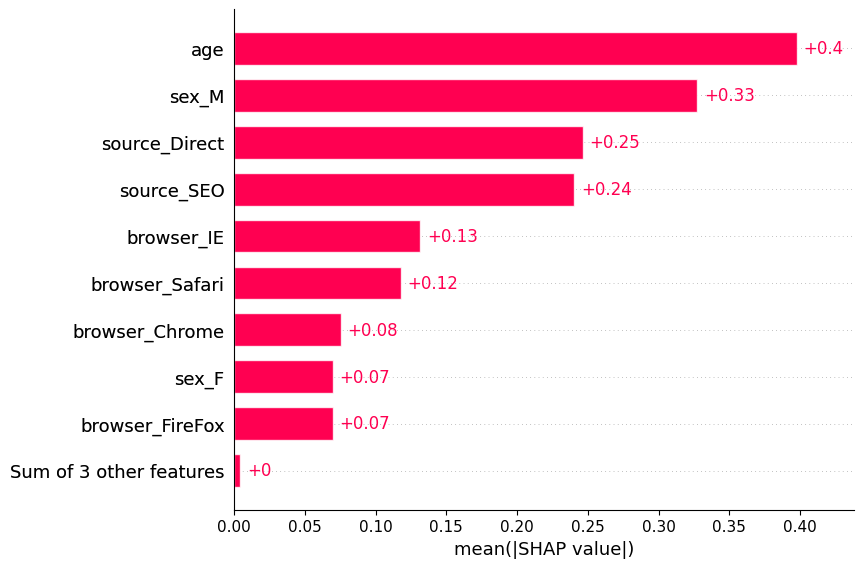

In [7]:
# Sample a portion for SHAP explanation
sample_data = Xf_test.sample(n=1000, random_state=42)

# Convert boolean columns to int for SHAP compatibility
sample_data_numeric = sample_data.copy()
for col in sample_data_numeric.select_dtypes(include='bool').columns:
	sample_data_numeric[col] = sample_data_numeric[col].astype(int)

# Remove non-numeric/object columns (e.g., 'user_id') for SHAP compatibility
sample_data_numeric_shap = sample_data_numeric.drop(columns=['user_id'])

# Ensure columns match explainer's expected features
expected_features = Xf_train.drop(columns=['user_id']).columns
sample_data_numeric_shap = sample_data_numeric_shap[expected_features]

# SHAP TreeExplainer for XGBoost
explainer = shap.Explainer(xgb_fraud, Xf_train.drop(columns=['user_id']).astype(float))

# Compute SHAP values
shap_values = explainer(sample_data_numeric_shap)


shap.summary_plot(shap_values, sample_data_numeric_shap)

shap.plots.bar(shap_values)

# Pick one row (e.g., index 0 from sample)
shap.plots.force(shap_values[0])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, sample_data_numeric_shap.iloc[0])